In [14]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.integrate as integrate
from numba import jit,njit,vectorize, float64, int32
import numba as nb
import time as time
## ---------------- Mathplotlib settings ----------------
SMALL_SIZE = 12
MEDIUM_SIZE = 22
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

<!-- ### Try an adaptive stepsize that is easy to control: 

We can try 
$$
   f(x)= (\Delta t_{\text{max}}-\Delta t_{\text{min}}) \left(1-\exp(- x R) \right)+ \Delta t_{\text{min}},
$$
with 
$$
   f'(x)= (\Delta t_{\text{max}}-\Delta t_{\text{min}}) R \exp(- x R).
$$
This is one example that is typically not based on the geometry of the problem but rather making the step smaller near the well of the potential. Alternatively, we could imagine a linear growth with a minimal value: 
$$
   f(x)= (\Delta t_{\text{max}}-\Delta t_{\text{min}}) R x+ \Delta t_{\text{min}},
$$
$$
   f'(x)= (\Delta t_{\text{max}}-\Delta t_{\text{min}}) R 
$$

Below, I plot those two examples of step sizes.  -->



### Overdamped Langevin Adaptive

Simulate the dynamics of 

$$
dx = F(x) dt + \sqrt{2} dW(t)
$$

using the modified sde : 
$$
dy = g(y)F(y) ds+ g'(y) ds + \sqrt{2 g(y)} dW(s)
$$

We use the system already extensively studied: 

$$
F(x)=-\nabla V(x) \\
V(x)= \frac{1}{2 x^2} +x^2\\
F(x)= -\frac{1}{x^3}+2x
$$

Ultimately we would like to use the geometry of the problem, such as using the absolute value of $ f(x) =\|-\nabla V(x)\| = \| -\frac{1}{x^3}+2x\|$. 
The idea is to use 
$$ g(x) = \frac{1}{F(x)} \\ 
 g(x) = \frac{1}{\|-\nabla V(x)\|} \\ 

g(x) = \frac{1}{ \|-\frac{1}{x^3}+2x\| }$$
and 
$$ g'(x) =\frac{- \|\frac{3}{x^4}+2\|}{\|-\frac{1}{x^3}+2x\|^2} $$


The issue is that we would also like to have some control regarding the minimum and maximum value taken by the time steps. Therefore, we can create a new function which bounds the value of $\frac{1}{\|-\nabla V(x)\|}$ such that the modified time $g(x)\Delta s$ stays bounded between $\Delta t_{min}=0.001$ and $\Delta t_{max}=0.1$. We follow the steps in Huang&Leimkuhler and set $m=\frac{\Delta t_{min}}{\Delta s}$ and $M= \frac{\Delta t_{max}}{\Delta s}$ and set the function: $f(x)= \|-\nabla V(x)\|$. We define $g^{-1}$, the inverse of the function $g(x) = \frac{1}{f(x)}$ as:
$$
g^{-1}(x) = \frac{\sqrt{ \|f(x)\|^2+m^2}}{\frac{1}{M}\sqrt{\|f(x)\|^2+m^2}+1},
$$
such that : 
$$
g(x) = \frac{\frac{1}{M}\sqrt{\|f(x)\|^2+m^2}+1}{\sqrt{ \|f(x)\|^2+m^2}} 
$$

One need to be carefull about the norm of the function $\|f(x)\| = \phi(f(x))$, where $\phi(x) = \|x\| = \sqrt{x^2}$, which should be written more carefully in this way: 
$$
\begin{aligned}
g(x) &= \frac{\frac{1}{M}\sqrt{\phi(f(x))^2+m^2}+1}{\sqrt{ \phi(f(x))^2+m^2}}\\
g(x) &= \frac{1}{M} + \frac{1}{\sqrt{ \phi(f(x))^2+m^2}}
\end{aligned}
$$

such that when we look for the derivative, we obtain: 
$$
    g'(x) = - \frac{\phi(f(x)) \frac{d\phi(f(x))}{dx}}{(f(x)^2 + m^2)^{3/2}}
$$
We have that:
$$
\begin{aligned}
\frac{d\phi(f(x))}{dx}  &= \frac{d\phi(f(x))}{df(x)} \frac{df(x)}{dx}  \\
\frac{d\phi(f(x))}{dx}  &= \frac{1}{2} \frac{2 f(x)}{\phi(f(x))} f'(x) \\
\frac{d\phi(f(x))}{dx}  &= \frac{f(x)}{\phi(f(x))} f'(x).
\end{aligned}
$$
resulting in : 
$$
    g'(x) = - \frac{ f(x)f'(x)}{(f(x)^2 + m^2)^{3/2}}
$$

We do have that : $\phi(f(x)) = \| f(x) \| = \sqrt{((1/x^3)-2x)^2}$, $f(x) = 1/x^3 - 2x$, $f'(x) = -(\frac{3}{x^4}+2)$, and  $\phi(f(x))^2 = \| f(x) \|^2 = \sqrt{((1/x^3)-2x)^2}^2 = f(x)^2$

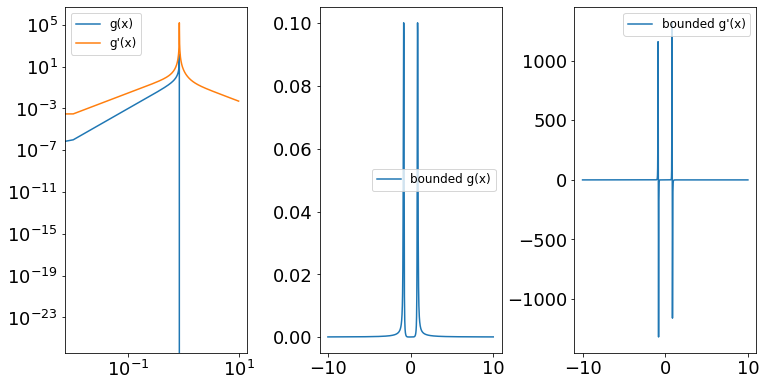

In [2]:
def g(x): 
    # value of function f, f' and f^2
    x3=np.power(x,3)
    f=(1/x3-2*x)
    fprime=-(3/(x3*x)+2)
    f2 = f*f

    gx = 1/f
    gxprime = -fprime/f2
    
    #return
    re=np.array([gx,gxprime])
    return re
    
def g4_plot(x,h,dtmin,dtmax):
    """
    Compute the value of the adaptive function choosen:
    x: float 
    """

    M=h/dtmin
    
    m=h/dtmax
    x3=np.power(x,3)

    # value of function f, f' and f^2
    f=(1/x3-2*x)
    fprime=-(3/(x3*x)+2)

    f2 = f*f

    #compute the value of phi(f(x)) = \sqrt{f(x)^2}
    phif = np.sqrt(f2)
    phif2 = f2*f2

    # value of m^2
    m2 = m*m

    #compute gx
    gx_den=np.sqrt(phif2+m2)
    gx_num = gx_den/M + 1 
    gx=gx_num/gx_den

    #compute gx prime 
    gxp_num=- f*fprime
    gxp_den = gx_den*gx_den*gx_den
    gxprime= gxp_num/gxp_den
    gxprime = np.round(gxprime,6)
    #return
    re=np.array([gx,gxprime])
    return re


fig, (ax1,ax2,ax3)= plt.subplots(1, 3,figsize=(12,6))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1,right=0.9, top=0.9, wspace=0.4, hspace=0.4)
dt=0.01
dtbounds = np.array([0.0001,0.1])
dtmin=dtbounds[0]
dtmax = dtbounds[1]
x=np.arange(-10,10,0.01)
gx4_test = g4_plot(x,dt,dtmin,dtmax)

ax1.loglog(x,g(x)[0,::],label="g(x)")
ax1.loglog(x,g(x)[1,::],label="g'(x)")
ax2.plot(x,gx4_test[0,::]*dt,label="bounded g(x)")
ax3.plot(x,gx4_test[1,::],label="bounded g'(x)")
ax1.legend()
ax2.legend()
ax3.legend()

In [20]:
#%time ytest=y_compile = DW_sde_fast(1000,3,10,0.01,20) # compile the function
def plot_dist(y,tau,dt,n_samples,T,title,ax):
    ax.set_title(str(title)) #+", $\\tau$="+str(tau)+", h="+str(dt)+", \n N="+str(n_samples)+", T="+str(T))

    #Plot 1
    histogram,bins = np.histogram(y,bins=100,range=[-5,5], density=True)

    midx = (bins[0:-1]+bins[1:])/2
    histogram=(histogram/np.sum(histogram))
    ax.plot(midx,histogram,label='q-Experiment')

    rho = np.exp(- (U(midx)/tau))
    rho = rho / ( np.sum(rho) * (midx[1]-midx[0]) ) 
    rho=(rho/np.sum(rho))*2
    rho=[rho[i] if i>50 else 0 for i in range(len(rho))]
    ax.plot(midx,rho,'--',label='Truth') 
    ax.legend()

<!-- We set up 3 files with the three different functions we discussed above; 
1. "infinitedoublewell_adaptive_gx1" uses $g(x)= (\Delta t_{\text{max}}-\Delta t_{\text{min}}) \left(1-\exp(- x R) \right)+ \Delta t_{\text{min}}$
2. "infinitedoublewell_adaptive_gx2" uses $g(x)= (\Delta t_{\text{max}}-\Delta t_{\text{min}}) R x+ \Delta t_{\text{min}}$
3. "infinitedoublewell_adaptive_gx3" uses $g(x) =  \frac{\frac{1}{M}(\|f(x)\|+m)+1}{\|f(x)\| + m}.$. -->
4. "infinitedoublewell_adaptive_gx4" uses $g(x) = \frac{\frac{1}{M}\sqrt{\|f(x)\|^2+m^2}+1}{\sqrt{ \|f(x)\|^2+m^2}}$

In [8]:
%run "/home/s2133976/OneDrive/ExtendedProject/codingUsingNumba/WeakSDEapproximation/numba code/infinitedoublewell_adaptivegx4.py"
%run "/home/s2133976/OneDrive/ExtendedProject/codingUsingNumba/WeakSDEapproximation/numba code/infinitedoublewell_nsample.py"

Fistlty we need to make a quick visual check to make sure that each adaptive method seems to be converging towards the actual method of interest. 

In [9]:
%time ytest= IDW_nsample_ada4(10,1,0.1,np.array([0.01,0.1]))   # compile the function
%time y_nonada= IDW_nsample(10,1,1,1)

CPU times: user 404 ms, sys: 39 µs, total: 404 ms
Wall time: 403 ms
CPU times: user 578 ms, sys: 0 ns, total: 578 ms
Wall time: 403 ms


In [18]:
n_samples=10**4
T=100
dtnonada=0.01
tau=1
%time y_nonada= IDW_nsample(n_samples,T,dtnonada,tau)

CPU times: user 2min 8s, sys: 108 ms, total: 2min 9s
Wall time: 11.6 s


In [19]:
n_samples=10**4
dt=0.01
dtbounds = np.array([0.001,0.01])
%time y_adag4= IDW_nsample_ada4(n_samples,T,dt,dtbounds) 

CPU times: user 26min 37s, sys: 921 ms, total: 26min 38s
Wall time: 2min 17s


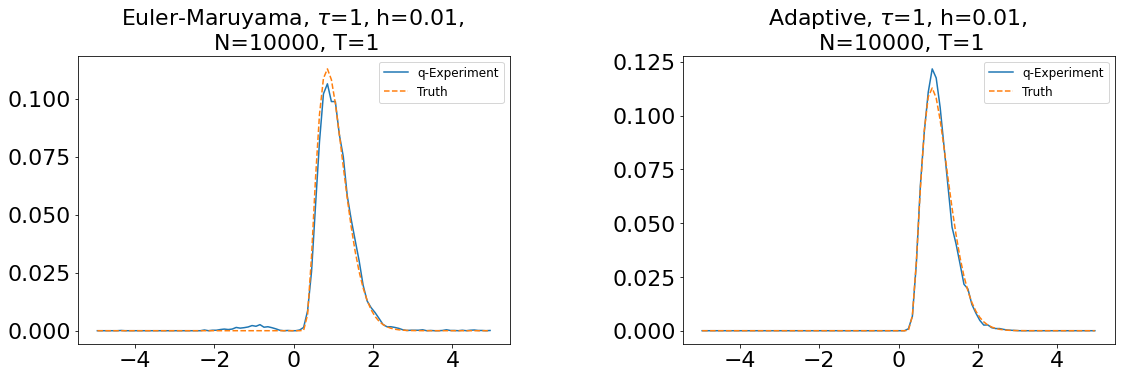

In [17]:
fig, ((ax1,ax2))= plt.subplots(1,2,figsize=(18,5))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)
plot_dist(y_nonada,tau,dtnonada,n_samples,T,"Euler-Maruyama",ax1)
plot_dist(y_adag4,tau,dt,n_samples,T,"Adaptive",ax2)


Test the adaptive method with different values of $\Delta t$, generally, we need that $g'(x)$ stays bounded in order to obtain good results, see examples below: 

CPU times: user 15.8 s, sys: 16 ms, total: 15.8 s
Wall time: 1.39 s


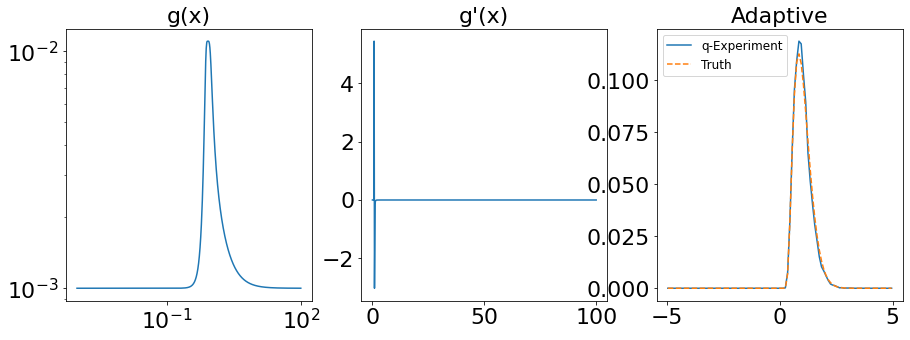

In [21]:
n_samples=10000
T=1
tau=1
dt=0.01
dtbounds = np.array([0.001,0.01])

## Figure set up 
fig, (ax1,ax2,ax3)= plt.subplots(1,3,figsize=(15,5))# plt.figure(figsize=(4,4))

## Plot the values of g and g'
dtmin=dtbounds[0]
dtmax = dtbounds[1]
x=np.arange(0.001,100,0.01)
gx4_test = g4_plot(x,dt,dtmin,dtmax)
ax1.loglog(x,gx4_test[0,::]*dt,label="g(x)")
ax1.set_title("g(x)")
ax2.plot(x,gx4_test[1,::],label="g(x)")
ax2.set_title("g'(x)")
## Compute the distribution 
%time y_adag4= IDW_nsample_ada4(n_samples,T,dt,dtbounds) 
plot_dist(y_adag4,tau,dt,n_samples,T,"Adaptive",ax3)



CPU times: user 7min 10s, sys: 439 ms, total: 7min 10s
Wall time: 38.2 s


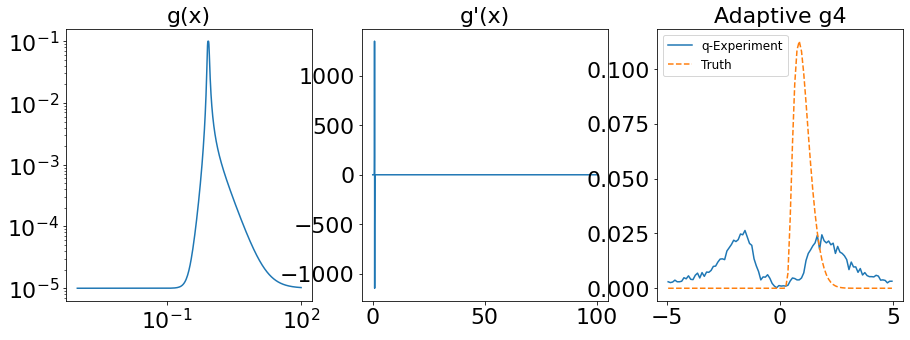

In [22]:
n_samples=10000
dt=0.01
tau=1
dtbounds = np.array([0.00001,0.1])

## Figure set up 
fig, (ax1,ax2,ax3)= plt.subplots(1,3,figsize=(15,5))# plt.figure(figsize=(4,4))

## Plot the values of g and g'
dtmin=dtbounds[0]
dtmax = dtbounds[1]
x=np.arange(0.001,100,0.01)
gx4_test = g4_plot(x,dt,dtmin,dtmax)
ax1.loglog(x,gx4_test[0,::]*dt,label="g(x)")
ax1.set_title("g(x)")
ax2.plot(x,gx4_test[1,::],label="g(x)")
ax2.set_title("g'(x)")
## Compute the distribution 
%time y_adag4= IDW_nsample_ada4(n_samples,T,dt,dtbounds) 
plot_dist(y_adag4,tau,dt,n_samples,T,"Adaptive g4",ax3)

CPU times: user 7.86 s, sys: 12 ms, total: 7.87 s
Wall time: 1.51 s


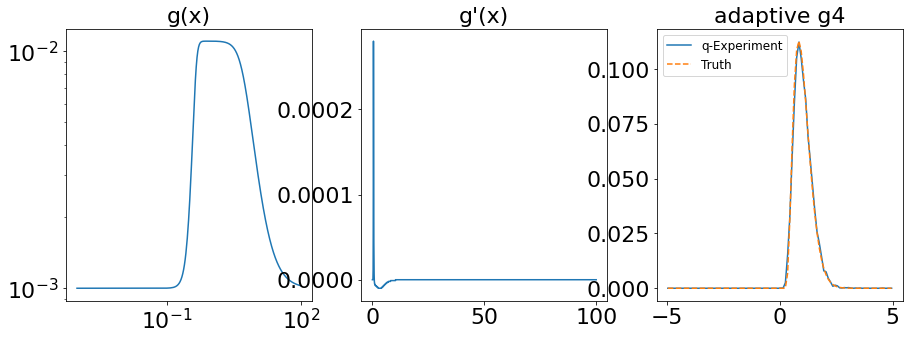

In [23]:
n_samples=10000
dt=1
dtbounds = np.array([0.001,0.01])
tau=1
## Figure set up 
fig, (ax1,ax2,ax3)= plt.subplots(1,3,figsize=(15,5))# plt.figure(figsize=(4,4))

## Plot the values of g and g'
dtmin=dtbounds[0]
dtmax = dtbounds[1]
x=np.arange(0.001,100,0.01)
gx4_test = g4_plot(x,dt,dtmin,dtmax)
ax1.loglog(x,gx4_test[0,::]*dt,label="g(x)")
ax1.set_title("g(x)")
ax2.plot(x,gx4_test[1,::],label="g(x)")
ax2.set_title("g'(x)")
## Compute the distribution 
%time y_adag4= IDW_nsample_ada4(n_samples,T,dt,dtbounds) 
plot_dist(y_adag4,tau,dt,n_samples,T,"adaptive g4",ax3)

Now we would like to compare our method against the normal one, to see whether it is a more accurate method. This is interesting to get some results on the Langevin adaptive method, however we can not vary $\tau$ as it is now fixed to $\tau = 1$, so what we can do is vary $\Delta t$ or change the type of function $g(x)$ we are looking at. This should be enough on this for now. 

### Ignore after here 

In [43]:
def nesc_eta_dtlist(n_samples,dt,T,b):
    """
    Function to establish the proportion of escaping trajectories
    Input :
    ------
    n_samples: int
        number of samples generated
    dt: float
        Time increment
    list_var: list of float
        list of values of the temperature to evaluate 
    T: int
        Final time until the solution is ran
    b: int
        Boundary selected
    """
    # empty vector to save results
    y_res = np.zeros((len(tau_var),n_samples))
    #list of escaping trajectories
    nesc_list=[]
    #run through the different values of tau 
    for i in range(len(tau_var)):
        tau_i=tau_var[i]
        y_exact = IDW_nsample(n_samples,T,dt,tau_i)
        y_res[i,::]=y_exact

        #compute the proportion of escaping trajectory
        res = len(y_exact[y_exact<0])+len(y_exact[y_exact>b])
        res = res/len(y_exact)
        nesc_list.append(res)
        
    return(nesc_list,y_res)

In [42]:
def nesc_eta_dtlistada(n_samples,dt,tau_var,T,b):
    """
    Function to establish the proportion of escaping trajectories
    Input :
    ------
    n_samples: int
        number of samples generated
    dt: float
        Time increment
    list_var: list of float
        list of values of the temperature to evaluate 
    T: int
        Final time until the solution is ran
    b: int
        Boundary selected
    """
    # empty vector to save results
    y_res = np.zeros((len(tau_var),n_samples))
    #list of escaping trajectories
    nesc_list=[]
    #run through the different values of tau 
    for i in range(len(tau_var)):
        tau_i=tau_var[i]
        y_exact = IDW_nsample_ada4(n_samples,T,dt,tau_i)
        y_res[i,::]=y_exact

        #compute the proportion of escaping trajectory
        res = len(y_exact[y_exact<0])+len(y_exact[y_exact>b])
        res = res/len(y_exact)
        nesc_list.append(res)
        
    return(nesc_list,y_res)

In [47]:
n_samples = 10
dt=0.01
b1=0.7
b2=2.3
inc=(b2-b1)/30
tau_list=np.round(np.arange(b1,b2+inc,inc),3)
T=100
#set up bound 
b=10

#compute the number of escaping trajectory
nesc_nonada, y_nonada = nesc_eta_taulist(n_samples,dt,tau_list,T,b)


In [191]:
dt=0.01

nesc_ada1, y_ada1 = nesc_eta_dtlistada(n_samples,dt,tau_list,T,b)




In [192]:
nesc_ada2, y_ada2 = nesc_eta_dtlist(n_samples,tau_list7,tau,T,b,IDW_nsample_ada2)


In [193]:
nesc_ada3, y_ada3 = nesc_eta_dtlist(n_samples,tau_list7,tau,T,b,IDW_nsample_ada3)

Text(0.5, 1.0, '$T=100$, $n_{samples}=10^5$')

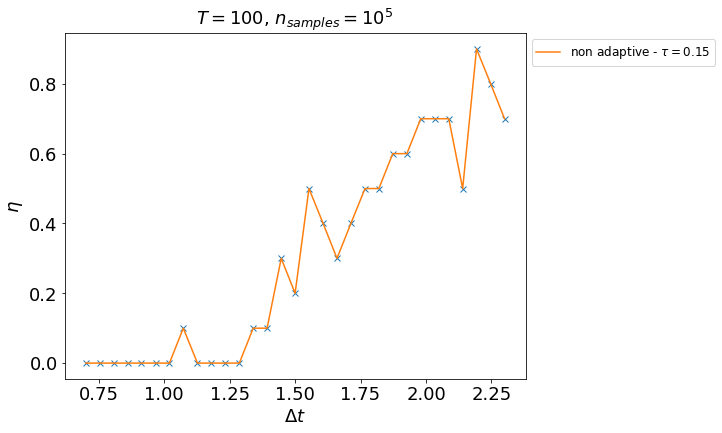

In [48]:
fig, (ax)= plt.subplots(1, 1,figsize=(8,6))# plt.figure(figsize=(4,4))
fig.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.4)

ax.plot(tau_list,nesc_nonada,"x") #plot non adaptive
ax.plot(tau_list,nesc_nonada,label="non adaptive - $\\tau=0.15$")

# 
# tau_list,nesc_nonada


ax.legend(loc='upper left', bbox_to_anchor=(1, 1)) #add the legend
ax.set_ylabel("$\eta $")
ax.set_xlabel("$\Delta t $")
ax.set_title("$T=100$, $n_{samples}=10^5$")